# Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from itertools import accumulate

# Gillespies Algorithm

In [ ]:
def run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=None):
                
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
# Define event chance
    def GetNextEventTime(event_rate):
        if event_rate > 0:
            delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
            return delta_t
        else:
            return float('inf')  # Set a large value for next event time if event rate is zero

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])
        next_event_times = []

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose event to execute according to minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series

# SIR Model

In [ ]:
# Define the deterministic SIR model
def SIR_model(y, t, beta, gamma, mu, N):
    S, I, R = y
    dSdt = mu * N - beta * S * I / N - mu * S
    dIdt = beta * S * I / N - mu * I - gamma * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]

# Stochastic Resonance

- vary N, beta 

In [ ]:
# Define parameters for the stochastic SIR model
beta_values = [0.1, 5]  
N_values = [200, 10000]  

# Other parameters
gamma = 0.05
mu = 1/70
infected_init = 5
recovered_init = 0
max_time = 1000
random_seed = 987 

# Initialize lists to store results
stochastic_results = []
deterministic_results = []

# Loop over beta and N combinations
for beta in beta_values:
    for N in N_values:
        # Run simulations for the stochastic SIR model
        time_series, X_series, Y_series, Z_series = run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time)

        stochastic_results.append((beta, N, time_series, X_series, Y_series, Z_series))  # Store results for plotting

        # Time points for the deterministic model
        t_deterministic = np.linspace(0, max_time, len(time_series))

        # Initial conditions for the deterministic model
        S0_deterministic = N - infected_init
        I0_deterministic = infected_init
        R0_deterministic = 0
        y0_deterministic = [S0_deterministic, I0_deterministic, R0_deterministic]

        # Solve the deterministic SIR model
        sol_deterministic = odeint(SIR_model, y0_deterministic, t_deterministic, args=(beta, gamma, mu, N))
        S_deterministic, I_deterministic, R_deterministic = sol_deterministic[:, 0], sol_deterministic[:, 1], sol_deterministic[:, 2]

        deterministic_results.append((beta, N, t_deterministic, S_deterministic, I_deterministic, R_deterministic))  # Store results for plotting

# Loop over beta and N combinations
for beta, N, time_series, X_series, Y_series, Z_series in stochastic_results:
    plt.figure(figsize=(12, 6))
    plt.rc('font', size=11.5) 
    plt.plot(time_series, X_series, label=f'Stochastic Susceptible', linestyle='--', alpha=0.7)
    plt.plot(time_series, Y_series, label=f'Stochastic Infected', linestyle='--', alpha=0.7)
    plt.plot(time_series, Z_series, label=f'Stochastic Recovered', linestyle='--', alpha=0.7)

    # Find the corresponding deterministic result for beta and N
    deterministic_result = next(result for result in deterministic_results if result[0] == beta and result[1] == N)
    t_deterministic, S_deterministic, I_deterministic, R_deterministic = deterministic_result[2], deterministic_result[3], deterministic_result[4], deterministic_result[5]
    plt.plot(t_deterministic, S_deterministic, label=f'Deterministic Susceptible', linestyle='-')
    plt.plot(t_deterministic, I_deterministic, label=f'Deterministic Infected', linestyle='-')
    plt.plot(t_deterministic, R_deterministic, label=f'Deterministic Recovered', linestyle='-')

    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(f' Examine Stochastic Resonance vs. Deterministic SIR Model \n N={N}, β={beta}, γ={gamma}, μ=1/70')
    plt.legend(loc='upper right')
    plt.grid(True)

#     plt.savefig(f'sir_resonance_N{N}_beta{beta}.png')  
    plt.clf()  


In [ ]:
# Define parameters
beta_values = [0.2, 5]
N_values = [200, 10000]
gamma = 0.05
mu = 1/70
infected_init = 5
recovered_init = 0
max_time = 1000

equilibrium_points = []

# Loop over beta and N combinations
for beta in beta_values:
    for N in N_values:
        t = np.linspace(0, max_time, max_time + 1)

        # Initial conditions
        S0 = N - infected_init
        I0 = infected_init
        R0 = recovered_init
        y0 = [S0, I0, R0]

        sol = odeint(SIR_model, y0, t, args=(beta, gamma, mu, N))
        
        # Get the equilibrium point at the end of the simulation
        S_eq, I_eq, R_eq = sol[-1]
        
        equilibrium_points.append((beta, N, S_eq, I_eq, R_eq))

# Print equilibrium points
for beta, N, S_eq, I_eq, R_eq in equilibrium_points:
    print(f"Equilibrium values for Beta={beta}, N={N}:")
    print(f"Susceptible (S): {S_eq}")
    print(f"Infected (I): {I_eq}")
    print(f"Recovered (R): {R_eq}")
    print("-" * 30)

# Increased Transients
- run it for multiple simulations and take the average. 

In [ ]:
def run_sir_simulation_phase(beta, gamma, mu, N, infected_init, recovered_init, max_time=365):

    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
    def GetNextEventTime(event_rate):
        if event_rate > 0:
            delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
            return delta_t
        else:
            return float('inf') 

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0

    # Lists to store the values for creating a phase-space diagram
    X_values = []
    Y_values = []
    Z_values = []

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])

        # Store values for the phase-space diagram
        X_values.append(X)
        Y_values.append(Y)
        Z_values.append(Z)

        next_event_times = []

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose the event to execute according to the minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series, X_values, Y_values, Z_values


In [ ]:
# Parameters for the deterministic/Stochastic SIR model
beta = 0.2
gamma = 0.05  # Recovery rate
mu = 1/70  # Birth/death rate
N = 200  # Total population
infected_init = 5
recovered_init = 0
random_seeds = [987]

# Initialize a list to store the results of multiple simulations
stochastic_results = []

# Number of simulations
num_simulations = len(random_seeds)

min_length = float('inf') 

for seed in random_seeds:
    np.random.seed(seed)

    # Run the stochastic SIR simulation
    _, _, _, _, X_values, Y_values, Z_values = run_sir_simulation_phase(
        beta, gamma, mu, N, infected_init, recovered_init, 365)

    # Append the results to the list
    stochastic_results.append((X_values, Y_values))

    # Determine the minimum length of the simulations
    min_length = min(min_length, len(X_values))

# Initialize arrays to store the average results
average_X_values = np.zeros(min_length)
average_Y_values = np.zeros(min_length)

# Calculate the average of the results
for X_values, Y_values in stochastic_results:
    average_X_values += np.array(X_values[:min_length])
    average_Y_values += np.array(Y_values[:min_length])

average_X_values /= num_simulations
average_Y_values /= num_simulations

# Initial conditions for the deterministic SIR model
initial_conditions = [N - infected_init - recovered_init, infected_init, recovered_init]

# Time points for the deterministic model
max_time = np.linspace(0, 365, min_length)

# Simulate the deterministic SIR model
solution_deterministic = odeint(SIR_model, initial_conditions, max_time, args=(beta, gamma, mu, N))
S, I, R = solution_deterministic.T

# Plot both the stochastic and deterministic SIR models on the same plot
plt.figure(figsize=(10, 6))
plt.rc('font', size=14) 
plt.plot(S, I, label='Deterministic SIR', linestyle='--')
plt.plot(average_X_values, average_Y_values, label='Stochastic SIR', alpha=0.5)

# Mark the final states with scatter points
plt.scatter([S[-1]], [I[-1]], c='blue', marker='x', label='Deterministic Final State')
plt.scatter([average_X_values[-1]], [average_Y_values[-1]], c='red', marker='o', label='Stochastic Final State')

# Mark the initial states with scatter points
plt.scatter([S[0]], [I[0]], c='green', marker='x', label='Deterministic Initial State')

plt.xlabel('Susceptible')
plt.ylabel('Infectious')
plt.title(f'SIR Phase-Space Diagram (Deterministic vs. Stochastic) \n N = 200, β={beta}, γ={gamma}, μ=1/70')
plt.legend()
plt.grid(True)
plt.savefig('SIR_high_transients_one_seed.png')  
plt.show()


In [ ]:
# Parameters for the deterministic/Stochastic SIR model
beta = 0.2
gamma = 0.05  # Recovery rate
mu = 1/70  # Birth/death rate
N = 10000  # Total population
infected_init = 5
recovered_init = 0
random_seeds = [987]

# Initialize a list to store the results of multiple simulations
stochastic_results = []

# Number of simulations
num_simulations = len(random_seeds)

min_length = float('inf')  

for seed in random_seeds:
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Run the stochastic SIR simulation
    _, _, _, _, X_values, Y_values, Z_values = run_sir_simulation_phase(
        beta, gamma, mu, N, infected_init, recovered_init, 365)

    # Append the results to the list
    stochastic_results.append((X_values, Y_values))

    # Determine the minimum length of the simulations
    min_length = min(min_length, len(X_values))

# Initialize arrays to store the average results
average_X_values = np.zeros(min_length)
average_Y_values = np.zeros(min_length)

# Calculate the average of the results
for X_values, Y_values in stochastic_results:
    average_X_values += np.array(X_values[:min_length])
    average_Y_values += np.array(Y_values[:min_length])

average_X_values /= (num_simulations * len(random_seeds))
average_Y_values /= (num_simulations * len(random_seeds))

# Initial conditions for the deterministic SIR model
initial_conditions = [N - infected_init - recovered_init, infected_init, recovered_init]

# Time points for the deterministic model
max_time = np.linspace(0, 365, min_length)

# Simulate the deterministic SIR model
solution_deterministic = odeint(SIR_model, initial_conditions, max_time, args=(beta, gamma, mu, N))
S, I, R = solution_deterministic.T

# Plot both the stochastic and deterministic SIR models on the same plot
plt.figure(figsize=(10, 6))
plt.rc('font', size=14)
plt.plot(S, I, label='Deterministic SIR', linestyle='--')
plt.plot(average_X_values, average_Y_values, label='Stochastic SIR', alpha=0.5)

# Final states for stochastic and deterministic
plt.scatter([S[-1]], [I[-1]], c='blue', marker='x', label='Deterministic Final State')
plt.scatter([average_X_values[-1]], [average_Y_values[-1]], c='red', marker='o', label='Stochastic Final State')

# Initial state for determinisitic 
plt.scatter([S[0]], [I[0]], c='green', marker='x', label='Deterministic Initial State')

plt.xlabel('Susceptible')
plt.ylabel('Infectious')
plt.title(f'SIR Phase-Space Diagram (Deterministic vs. Stochastic) \n N = 10000, β={beta}, γ={gamma}, μ=1/70')
plt.legend()
plt.grid(True)
plt.savefig('SIR_low_transients_one_seed.png')  
plt.show()

# Extinction events 
- think about varying beta or N and just plot its effect on the infected curve.

In [3]:
def run_sir_simulation_extinction(beta, gamma, mu, N, infected_init, recovered_init, max_time=365, random_seed=None):

    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        if X < 0:
            X = 0  # Reset X to 0 if it goes negative
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        if Z < 0:
            Z = 0  # Reset Z to 0 if it goes negative
        return Z

    # Define event chance
    def GetNextEventTime(event_rate):
        if event_rate > 0:
            delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
            return delta_t
        else:
            return float('inf')  # Set a large value for next event time if event rate is zero

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0
    extinction = []  # Initialize the list to track extinction times
    extinct_compartment = None  # Initialize variable to store the extinct compartment

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])
        next_event_times = []

        # Check for extinction
        if Y <= 0:
            extinction_time = time
            extinction.append(extinction_time)  # Track extinction time
            extinct_compartment = 'Infectious (Y)'
            break  # Stops the simulation 

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose event to execute according to minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Print when an extinction event occurred
#     if len(extinction) > 0:
#         print(f"Extinction occurred at time: {extinction[0]} in compartment: {extinct_compartment}")

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series, extinction, extinct_compartment

Running simulations for beta = 1


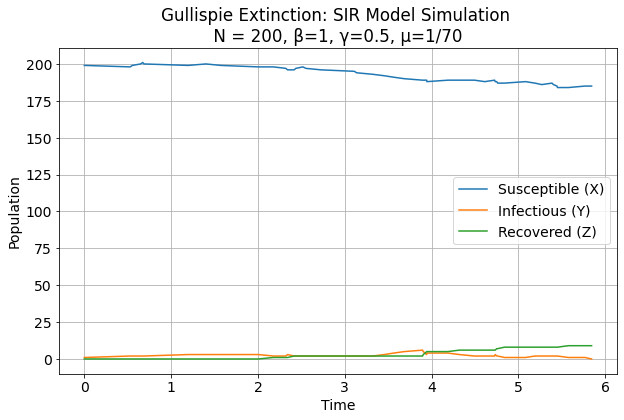

Beta: 1, Extinction Times: 5.841699124043552, Extinct Compartment: Infectious (Y)
Running simulations for beta = 4


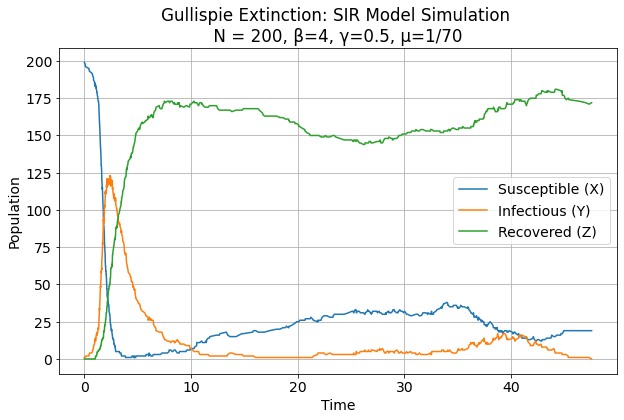

Beta: 4, Extinction Times: 47.56086566711633, Extinct Compartment: Infectious (Y)
Running simulations for beta = 6


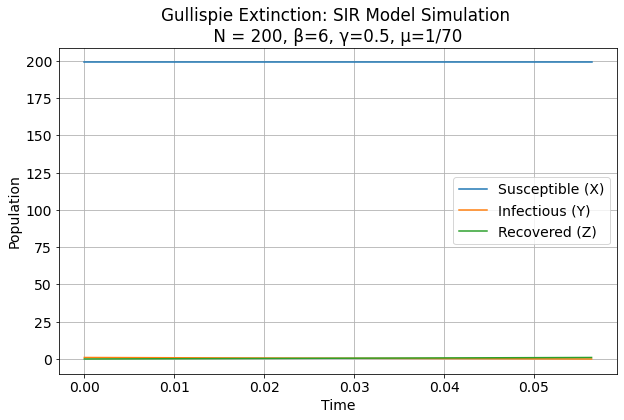

Beta: 6, Extinction Times: 0.05639569031402348, Extinct Compartment: Infectious (Y)
Running simulations for beta = 8


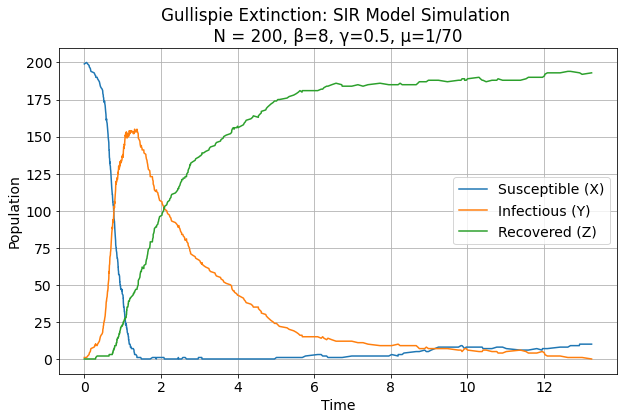

Beta: 8, Extinction Times: 13.239259072944478, Extinct Compartment: Infectious (Y)
Running simulations for beta = 10


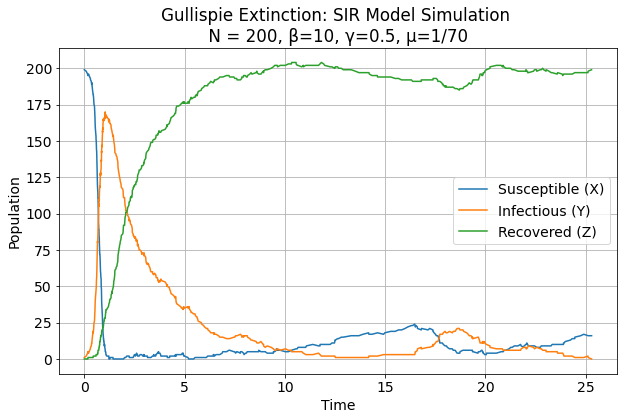

Beta: 10, Extinction Times: 25.29532263455157, Extinct Compartment: Infectious (Y)


In [6]:
# Parameters
gamma = 0.5
mu = 1/70
N = 200
infected_init = 1
recovered_init = 0
max_time = 365
n_simulations = 1 # Number of simulations per beta value

# Varying values of beta
beta_values = [1, 4, 6, 8, 10]
# Loop over different beta values
for beta in beta_values:
    print(f"Running simulations for beta = {beta}")
    extinction_info_all = []  # List to store extinction info for multiple simulations

    for _ in range(n_simulations):
        # Reset the extinction info list for each simulation
        extinction_info = {}

        time_series, X_series, Y_series, Z_series, extinction_times, extinct_compartment = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=None
        )

        # Append the information for this simulation to the list
        extinction_info["Beta"] = beta
        extinction_info["Extinction Times"] = ", ".join(map(str, extinction_times))
        extinction_info["Extinct Compartment"] = extinct_compartment

        extinction_info_all.append(extinction_info)

        # Plotting stuff
        plt.figure(figsize=(10, 6))
        plt.rc('font', size=14)
        plt.plot(time_series, X_series, label='Susceptible (X)')
        plt.plot(time_series, Y_series, label='Infectious (Y)')
        plt.plot(time_series, Z_series, label='Recovered (Z)')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title(f'Gullispie Extinction: SIR Model Simulation \n N = 200, β={beta}, γ={gamma}, μ=1/70 ')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Print extinction information for all simulations
    for simulation_info in extinction_info_all:
        print(f"Beta: {simulation_info['Beta']}, Extinction Times: {simulation_info['Extinction Times']}, Extinct Compartment: {simulation_info['Extinct Compartment']}")

Running simulations for beta = 1
Running simulations for beta = 4
Running simulations for beta = 7
Running simulations for beta = 10


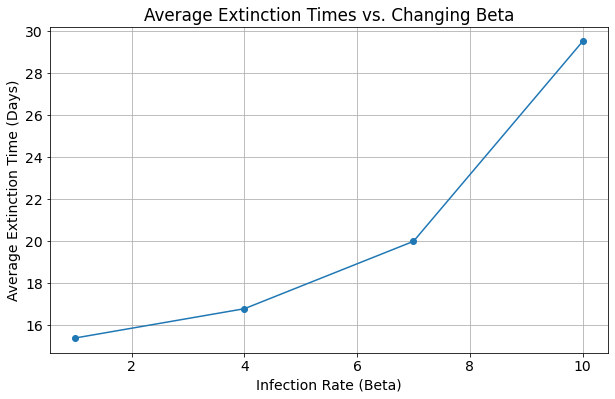

In [7]:
# Parameters
gamma = 0.5
mu = 1/70
N = 200
infected_init = 1
recovered_init = 0
max_time = 365

beta_values = [1, 4, 7, 10]

# Define the random seeds to use
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645, 3344, 3412, 3433, 331, 225, 527, 745, 887, 12]

# List to store average extinction times for 10 simulations
average_extinction_times = []

# Loop over different beta values and random seeds
for beta in beta_values:
    print(f"Running simulations for beta = {beta}")
    
    # List to store extinction times for multiple simulations
    extinction_times_all = []  

    for seed in random_seeds:
        # Reset the extinction times list for each simulation
        extinction_times = []

        _, _, _, _, extinction_times, _ = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=seed)

        extinction_times_all.append(extinction_times)  # Use extend, not append

    # Calculate the average of extinction times for this beta
    average_extinction_time = np.mean(extinction_times_all)
    average_extinction_times.append(average_extinction_time)

# Plot the average extinction times
plt.figure(figsize=(10, 6))
plt.plot(beta_values, average_extinction_times, marker='o')
plt.xlabel('Infection Rate (Beta)')
plt.ylabel('Average Extinction Time (Days)')
plt.title('Average Extinction Times vs. Changing Beta')
plt.grid(True)
# plt.savefig('SIR_extinction_change_in_beta.png') 
plt.show()

Average Extinction Time for beta = 1.0: 15.38331441375615 days
Average Extinction Time for beta = 2.0: 15.298486286619664 days
Average Extinction Time for beta = 3.0: 17.168042313638644 days
Average Extinction Time for beta = 4.0: 16.776589095077025 days
Average Extinction Time for beta = 5.0: 17.740574010672162 days
Average Extinction Time for beta = 6.0: 15.870481162676061 days
Average Extinction Time for beta = 7.0: 19.985429730598103 days
Average Extinction Time for beta = 8.0: 21.65023357826241 days
Average Extinction Time for beta = 9.0: 27.992360714369088 days
Average Extinction Time for beta = 10.0: 29.50164729499176 days
Average Extinction Time for beta = 11.0: 28.79333375069536 days
Average Extinction Time for beta = 12.0: 28.5514568665805 days
Average Extinction Time for beta = 13.0: 28.214440241353596 days
Average Extinction Time for beta = 14.0: 28.28964526603845 days
Average Extinction Time for beta = 15.0: 25.749172464402132 days
Average Extinction Time for beta = 16.0: 

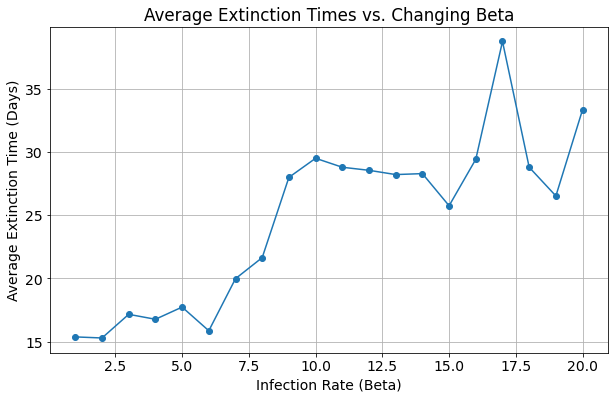

In [8]:
# Parameters
gamma = 0.5
mu = 1/70
N = 200
infected_init = 1
recovered_init = 0
max_time = 365

beta_values = np.linspace(1, 20, 20)

# Define the random seeds to use
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645, 3344, 3412, 3433, 331, 225, 527, 745, 887, 12]

# List to store average extinction times for 10 simulations
average_extinction_times = []

# Loop over different beta values and random seeds
for beta in beta_values:
#     print(f"Running simulations for beta = {beta}")
    
    # List to store extinction times for multiple simulations
    extinction_times_all = []  

    for seed in random_seeds:
        # Reset the extinction times list
        extinction_times = []

        _, _, _, _, extinction_times, _ = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=seed)
        extinction_times_all.append(extinction_times)  

    # Calculate the average of extinction times for this beta
    average_extinction_time = np.mean(extinction_times_all)
    average_extinction_times.append(average_extinction_time)

    # Print the average extinction time for this beta
    print(f"Average Extinction Time for beta = {beta}: {average_extinction_time} days")

    # Plot the average extinction times
plt.figure(figsize=(10, 6))
plt.plot(beta_values, average_extinction_times, marker='o')
plt.xlabel('Infection Rate (Beta)')
plt.ylabel('Average Extinction Time (Days)')
plt.title('Average Extinction Times vs. Changing Beta')
plt.grid(True)
plt.savefig('SIR_extinction_change_in_beta.png') 
plt.show()

Running simulations for N = 100
Running simulations for N = 500
Running simulations for N = 1000
Running simulations for N = 10000


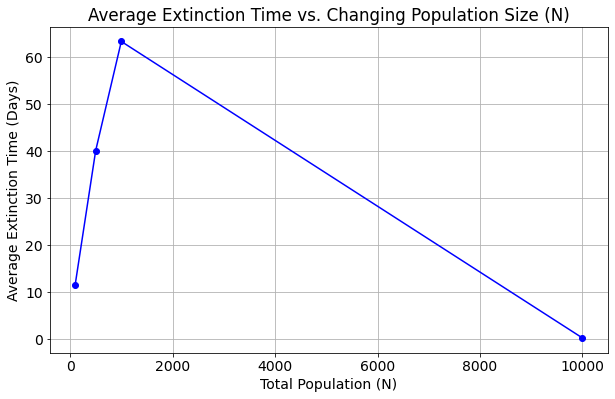

N: 100, Average Extinction Time: 11.609246638081213
N: 500, Average Extinction Time: 40.16154733603441
N: 1000, Average Extinction Time: 63.40102362229756
N: 10000, Average Extinction Time: 0.25040285421295044


In [13]:
# Parameters
gamma = 0.5
mu = 1/70
infected_init = 1
recovered_init = 0
max_time = 365
beta = 4  

N_values = [100, 500, 1000, 10000]

# Define the random seeds to use
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645, 3344, 3412, 3433, 331, 225, 527, 745, 887, 12]

average_extinction_times = []  
for N in N_values:
    print(f"Running simulations for N = {N}")
    extinction_times_all = [] 

    for seed in random_seeds:
        extinction_times = []

        _, _, _, _, extinction_times, _ = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=seed)

        extinction_times_all.extend(extinction_times)

    average_extinction_time = np.mean(extinction_times_all)
    average_extinction_times.append(average_extinction_time)

plt.figure(figsize=(10, 6))
plt.plot(N_values, average_extinction_times, marker='o', linestyle='-', color='b')
plt.xlabel('Total Population (N)')
plt.ylabel('Average Extinction Time (Days)')
plt.title('Average Extinction Time vs. Changing Population Size (N)')
plt.grid(True)
# plt.savefig('SIR_extinction_avg_change_in_N.png')
plt.show()
# adding stuff here 
for N, avg_ext_time in zip(N_values, average_extinction_times):
    print(f"N: {N}, Average Extinction Time: {avg_ext_time}")

Running simulations for N = 100
Running simulations for N = 500
Running simulations for N = 1000
Running simulations for N = 10000


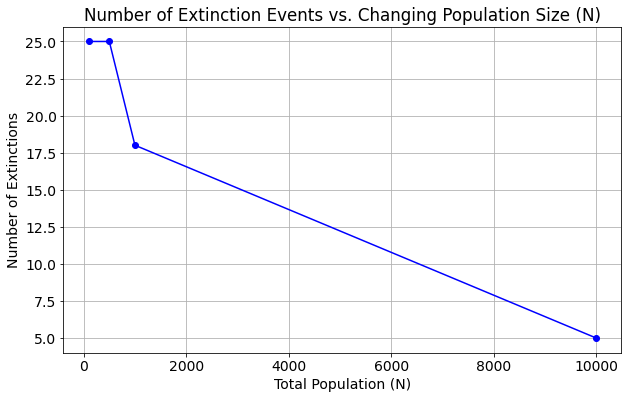

N: 100, Number of Extinctions: 25
N: 500, Number of Extinctions: 25
N: 1000, Number of Extinctions: 18
N: 10000, Number of Extinctions: 5


In [14]:
# Parameters
gamma = 0.5
mu = 1/70
infected_init = 1
recovered_init = 0
max_time = 365
beta = 4

# Varying values of N
N_values = [100, 500, 1000, 10000]

# Define the random seeds to use
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645, 3344, 3412, 3433, 331, 225, 527, 745, 887, 12]

extinction_counts = []  # List to store the number of extinction events for each N

# Loop over different N values and random seeds
for N in N_values:
    print(f"Running simulations for N = {N}")
    extinction_count = 0  # Initialize the extinction count for this N

    for seed in random_seeds:
        _, _, _, _, extinction_times, _ = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=seed)

        # Count the number of extinction events for this simulation
        extinction_count += len(extinction_times)

    # Append the extinction count for this N
    extinction_counts.append(extinction_count)

# Plot the number of extinctions as a function of N
plt.figure(figsize=(10, 6))
plt.plot(N_values, extinction_counts, marker='o', linestyle='-', color='b')
plt.xlabel('Total Population (N)')
plt.ylabel('Number of Extinctions')
plt.title('Number of Extinction Events vs. Changing Population Size (N)')
plt.grid(True)
plt.savefig('SIR_extinction_count_change_in_N.png')
plt.show()

# Print the number of extinction events
for N, extinction_count in zip(N_values, extinction_counts):
    print(f"N: {N}, Number of Extinctions: {extinction_count}")

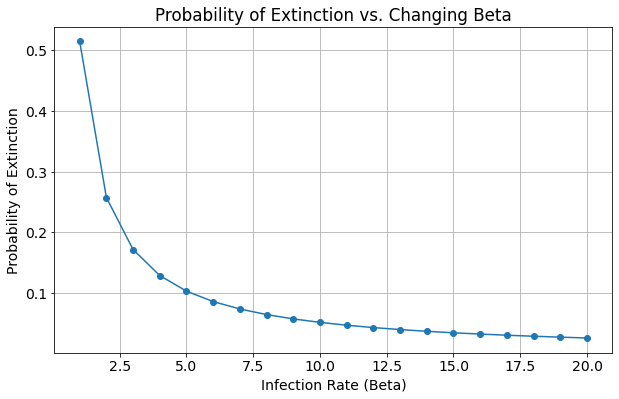

In [15]:
gamma = 0.5
mu = 1/70


beta_values = np.linspace(1, 20, 20)

# Calculate the probability of extinction for different beta values
extinction_probabilities = [(gamma + mu) / beta for beta in beta_values]

# Plot the probability of extinction
plt.figure(figsize=(10, 6))
plt.plot(beta_values, extinction_probabilities, marker='o')
plt.xlabel('Infection Rate (Beta)')
plt.ylabel('Probability of Extinction')
plt.title('Probability of Extinction vs. Changing Beta')
plt.grid(True)
plt.show()

# CCS